# Cantilever beam physics-informed neural network (PINN)

## Problem overview - this notebook tries to follow the method outlined in Yuan et al 2020

The example problem we solve here is a continuous beam:
$$ \rho A \frac{\partial^2w}{\partial t^2} + E I \frac{\partial^4w}{\partial x^4} + \rho A c \frac{\partial w}{\partial t} = f(t) $$
$$ w(x, t) = \sum_{j=1}^{\infty}\varphi_j(x)q_j(t) \approx \sum_{j=1}^{n}\varphi_j(x)q_j(t) $$
where $\varphi_j$ and $q_j$ are the $j^{th}$ modal shape and coordinate of the $j^{th}$ mode, respectively.
$$
\mathbf{M}\ddot{\mathbf{q}}(t) + \mathbf{C}\dot{\mathbf{q}}(t) + \mathbf{K}\mathbf{q}(t) = \mathbf{S_p}\mathbf{p}(t)
$$
where,
$$
\mathbf{M} = \rho A \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{C} = \rho Ac \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{K} = EI \int_0^l\mathbf{\psi}(x){\mathbf{\psi}''''}^T(x) dx
$$
in the state space,
$$
\dot{\mathbf{\tau}}(t) = \mathbf{A} \mathbf{\tau}(t) + \mathbf{H} \mathbf{f}(t)
$$
where,
$$
\mathbf{\tau} = \begin{bmatrix} \mathbf{q}(t) \\ \dot{\mathbf{q}}(t) \end{bmatrix}, \qquad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \qquad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}, \qquad
\mathbf{f}(t) = m_e g\mathbf{\Psi}(x_e)\mathbf{I}
$$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} \mathbf{q}(t) \\ \ddot{\mathbf{q}}(t) \end{bmatrix} $$

<!-- $$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \mathcal{L}_a + \lambda\left[ \mathcal{L}_{ode} \right]
$$
$$
\mathcal{L}_a = \langle \varphi_{kj}\hat{q}_j - y_k^* \rangle
$$
$$
\mathcal{L}_{ode,j} = \langle \hat{\ddot{q}}_j + 2\hat{\zeta}\hat{\omega}_j\hat{\dot{q}}_j + \hat{\omega}^2\hat{q}_j - p^*_j \rangle, \qquad
\mathcal{L}_{ode,j} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{q}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} \rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{q} + \tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{q} + \tilde{k} \hat{q} = 0, \qquad \hat{m} \partial^2_{\hat{t}}\hat{q} + \hat{c} \partial_{\hat{t}}\hat{q} + \hat{k}\hat{q} = 0
$$
> trad(itional)
$$
\hat{m} = \frac{1}{\alpha_t^2}, \quad \hat{c} = \tilde{c}\frac{1}{\alpha_t}, \quad \hat{k} = \tilde{k}
$$
> up_time
$$
\hat{m} = \frac{1}{\alpha_t}, \quad \hat{c} = \tilde{c}, \quad \hat{k} = \tilde{k}\alpha_t
$$
> up_time2
$$
\hat{m} = 1, \quad \hat{c} = \tilde{c}\alpha_t, \quad \hat{k} = \tilde{k}\alpha_t^2
$$ -->

In [36]:
from cont_pinn import bbnn, beam_pinn_Yuan, normalise
from beam_solutions import cont_beam
from math import pi

import numpy as np
import torch
import torch.nn as nn
device = torch.device("mps")
from torch_pso import ParticleSwarmOptimizer

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate training data

In [2]:
def gen_beam_params(E, rho, EI, pA):
    I_ = EI/E
    A_ = pA/rho
    h = (2*I_/A_)**(0.5)
    b = A_/h
    I = (1/12) * b * h**3
    A = b * h
    return I, A, b, h

def plot_vib_surface(ax, x, time, w, sub_samp=10):
    if len(x.shape) == 1 and len(time.shape) == 1:
        xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and time.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(time[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and time.shape[1] <= 1:
            xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def plot_vib_scatter(ax, x, time, w, color='grey'):
    ax.scatter3D(x, time, w, color=color)
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = torch.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

def roll_mat(data, n1, n2):
    data_ = torch.zeros((n1, n2))
    d_count = 0
    for i in range(n1):
        for j in range(n2):
            data_[i, j] = data[d_count]
            d_count += 1
    return data_

def gen_NN_data(x, t, w, phi=None):
    nd = x.shape[0] * t.shape[0]
    dc = 0
    x_vec, t_vec, w_vec = np.zeros((nd,1)), np.zeros((nd,1)), np.zeros((nd,1))
    if phi != None:
        phi_vec = np.zeros((nd, phi.shape[1]))
    for i in range(x.shape[0]):
        for j in range(t.shape[0]):
            x_vec[dc] = x[i]
            t_vec[dc] = t[j]
            w_vec[dc] = w[i,j]
            if phi != None:
                phi_vec[dc,:] = phi[i,:]
            dc += 1
    if phi == None:
        return torch.tensor(x_vec, dtype=torch.float32).view(-1,1), torch.tensor(t_vec, dtype=torch.float32).view(-1,1), torch.tensor(w_vec, dtype=torch.float32).view(-1,1)
    else:
        return torch.tensor(x_vec, dtype=torch.float32).view(-1,1), torch.tensor(t_vec, dtype=torch.float32).view(-1,1), torch.tensor(w_vec, dtype=torch.float32).view(-1,1), torch.tensor(phi_vec, dtype=torch.float32)
    
def closest_square(n: int, rem=False):
    x1 = int(np.floor(np.sqrt(n)))
    x2 = int(np.floor((n / x1)))
    if not rem:
        return x1, x2
    else:
        return x1, x2, int(n - (x1*x2))

In [3]:
# get the analytical solution over the full domain
l = 1.0
mu = 4.0

nx = 64
nt = 64
n_modes = 4

x = torch.linspace(0,1,nx)
t = torch.linspace(0,0.15,nt)

xx, tt = torch.meshgrid((x, t), indexing="ij")

w0_func = lambda x : 1.0 * torch.sin(3*pi*x)
w0 = w0_func(x)
v0 = torch.zeros(nx)

wxt = torch.sin(3*pi*xx) * torch.cos(9*(pi**2)*tt)  # ground truth data

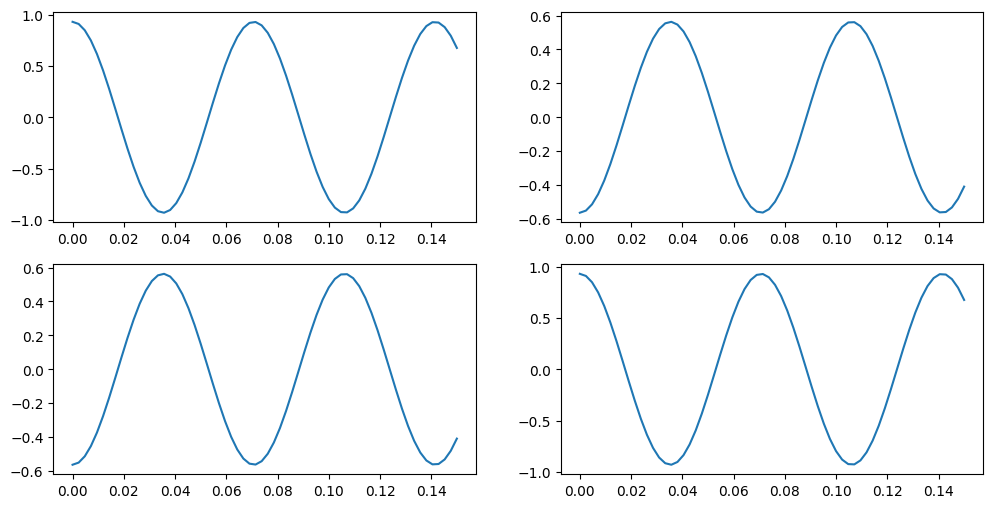

In [4]:
# s_locs = [0.25, 0.5, 0.75]
n_sens = 4  # number of sensors
sens_distance = x[-1]/(n_sens+1)  # distance between sensors
s_locs = np.arange(sens_distance, x[-1], sens_distance)  # target location of sensors
s_ids = [np.argmin(np.abs(x - s_locs[i])) for i in range(n_sens)]  # sensor ids from gt data

plot_locs = [0.25, 0.5, 0.75]  # target locations for plotting
plot_ids_ss = [np.argmin(np.abs(x[np.array(s_ids)] - plot_locs[i])) for i in range(3)]  # plotting location ids, relative to sensor dataset
plot_locs_ = [x[s_ids[k]] for k in plot_ids_ss]
plot_ids_gt = [np.argmin(np.abs(x - plot_locs_[i])) for i in range(3)]  # plotting location ids, relative to gt dataset, by takng closest of sensor dataset

n1, n2, n_rem = closest_square(n_sens, rem=True)
fig, axs = plt.subplots(n1, n2, figsize = (12,6))
axs = axs.ravel()
for i in range(n_sens-n_rem):
    axs[i].plot(t, wxt[s_ids[i],:])
    # axs[i].plot(t, wxt_n[s_ids[0],:,i],linestyle='--')

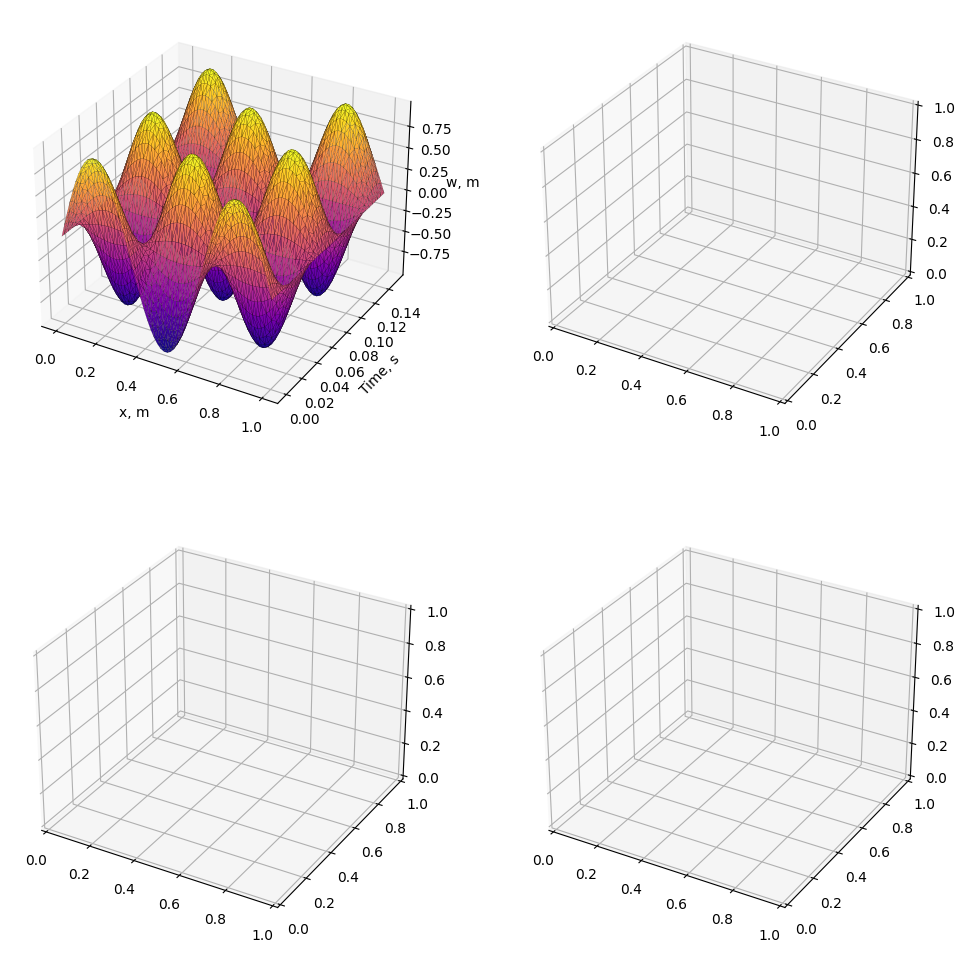

In [5]:
fig, axs = plt.subplots(2, 2, subplot_kw = {"projection":"3d"}, figsize=(12,12))
axs = axs.ravel()
plot_vib_surface(axs[0], x, t, wxt, 1)
# plot_vib_surface(axs[1], xx, t, wxt_n[:,:,0], 1)
# plot_vib_surface(axs[2], xx, t, wxt_n[:,:,1], 1)
# plot_vib_surface(axs[3], xx, t, wxt_n[:,:,2], 1)

Normalise

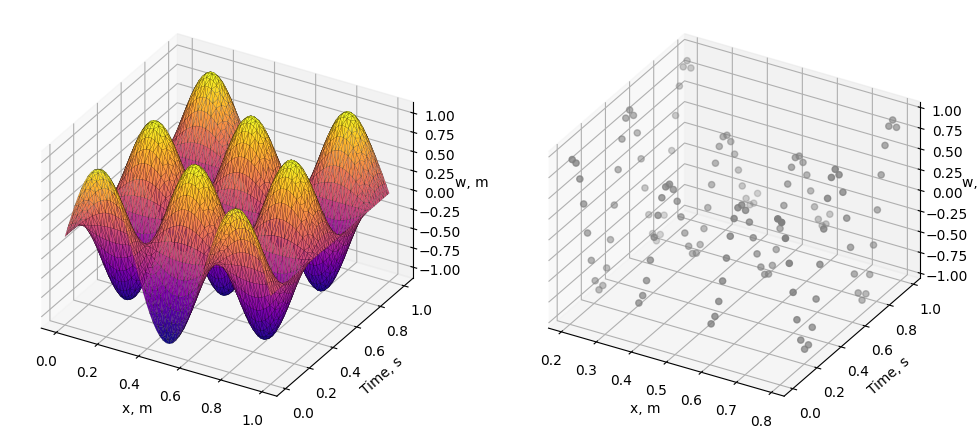

In [6]:
t_hat, alpha_t = normalise(t, "range")
x_hat, alpha_x = normalise(x, "range")
w_hat, alpha_w = normalise(wxt, "range", "all")

alphas = {
    "x" : alpha_x,
    "t" : alpha_t,
    "w" : alpha_w
}

# sub_ind_x = np.arange(0, int(nx/4), 1)
sub_ind_x = torch.tensor(s_ids)  # indices for sub-selection along x (sensor data)
sub_ind_t = np.arange(0, int(nt/1), 2)  # indices for sub-selection along time

x_data_vec = x_hat[sub_ind_x]  # vector of x data of sensors (observations)
t_data_vec = t_hat[sub_ind_t]  # vector of time data of sensors (observations)

w_data_mat = w_hat[:, sub_ind_t][sub_ind_x, :]

sens_ids_ = [torch.argmin(torch.abs(x_data_vec - plot_locs[i]/alpha_x)) for i in range(3)]
# s_ids = [np.argmin(np.abs(xx - s_locs[i])) for i in range(3)]

x_data, t_data, w_data = gen_NN_data(x_data_vec, t_data_vec, w_data_mat)
x_pred, t_pred, w_pred = gen_NN_data(x_hat, t_hat, w_hat)

fig, axs = plt.subplots(1, 2, subplot_kw = {"projection":"3d", "proj_type":"ortho"}, figsize=(12,12))
plot_vib_surface(axs[0], x_hat, t_hat, w_hat, 1)
# axs[0].view_init(elev=0, azim=-90)

# plot_vib_surface(axs[1], x_data_vec, t_data_vec, w_data_mat, 1)
plot_vib_scatter(axs[1], x_data, t_data, w_data)
# axs[1].view_init(elev=0, azim=-90)

## 'Black-box' single-network architecture

$$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \langle  \hat{w}^* - \mathcal{N}_{\hat{w}} \rangle
$$

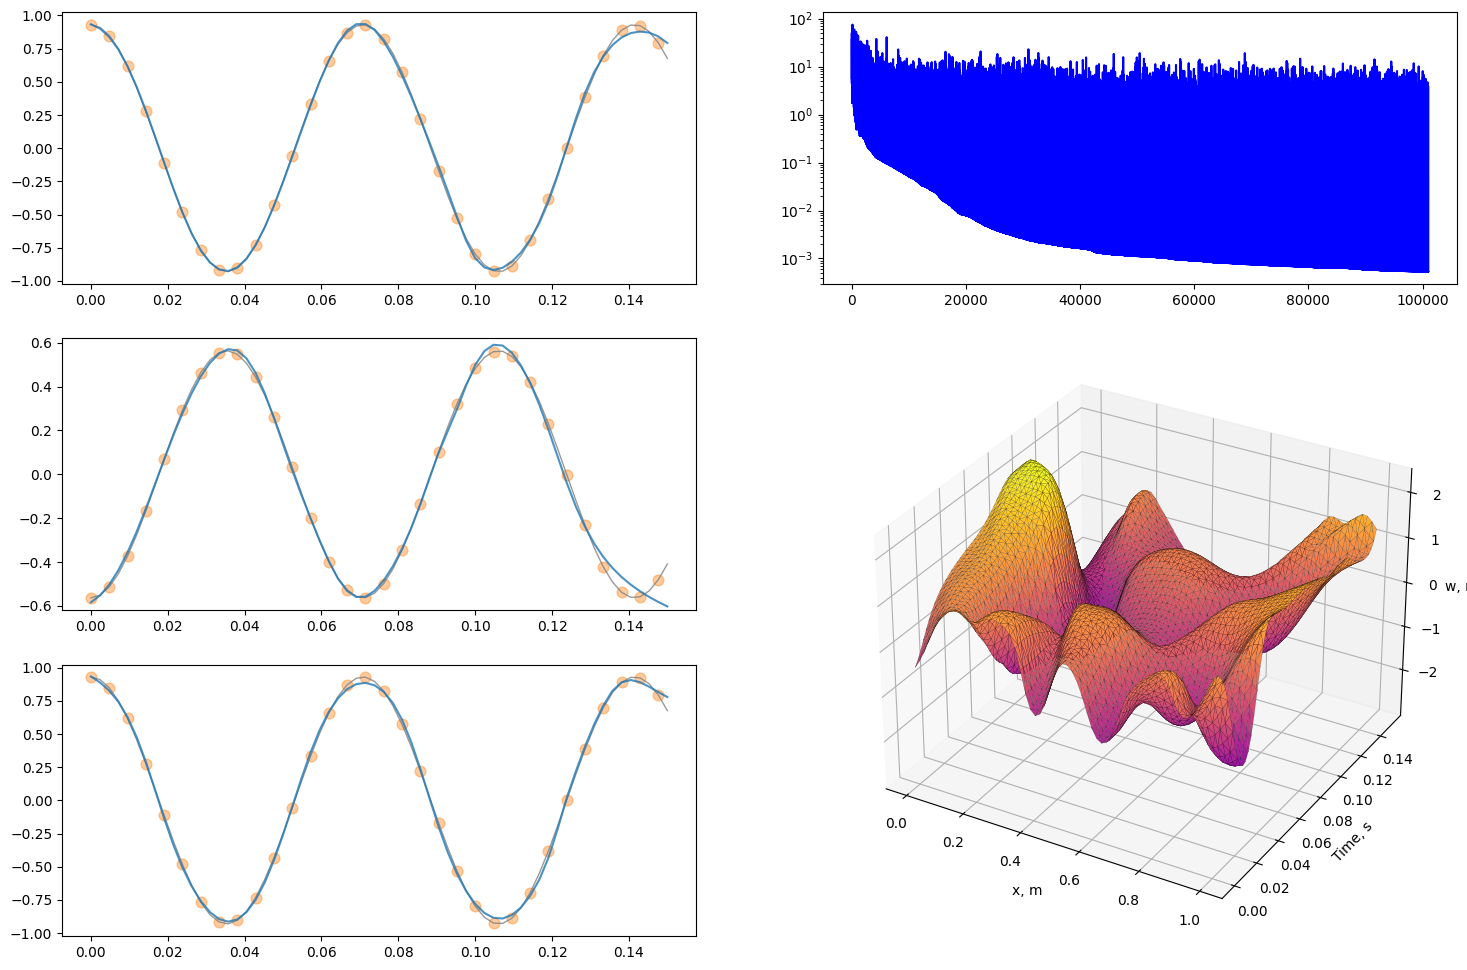

In [55]:
def plot_nn_update(axs_m, t_hat, w_hat, t_data, w_data, xpred, tpred, wpred, alphas):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(t_hat)*alphas["t"]
    for i in range(3):
        axs[i].plot(t_hat * alphas["t"], w_hat[plot_ids_gt[i],:] * alphas["w"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
        axs[i].plot(tpred * alphas["t"], wpred[plot_ids_gt[i],:] * alphas["w"], color="tab:blue", linewidth=1.5, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(t_data * alphas["t"], w_data[plot_ids_ss[i],:] * alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(w_hat[plot_ids_gt[i],:]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)
    axs_m['E'].cla()
    plot_vib_surface(axs_m['E'], xpred*alphas['x'], tpred*alphas['t'], wpred*alphas['w'], 1)
    # l = ax.legend(loc=(1.01,0.34), frameon=False, fontsize="large")

def plot_loss_hist(ax,loss_hist):
    # plt.figure(figsize=(6,6))
    ax.cla()
    n_epoch = len(loss_hist)
    ax.plot(np.arange(1,n_epoch+1),loss_hist,'b')
    ax.set_yscale('log')
    
# train standard neural network to fit training data
torch.manual_seed(43810)
epochs = int(1e3)
bb_model = bbnn(2,1,32,6)
optimizer = torch.optim.Adam(bb_model.parameters(),lr=1e-3)
optimizer = ParticleSwarmOptimizer(bb_model.parameters(),
                                   inertial_weight=0.5,
                                   num_particles=100,
                                   max_param_value=1,
                                   min_param_value=-1)
print_step = 50
loss_hist = []

# fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
# fig, axs = plt.subplot_mosaic("AD;BD;CD", figsize=(18,12), facecolor='w')
fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )
for i in tqdm(range(epochs)):

    def closure():
        optimizer.zero_grad()
        loss = bb_model.loss_func(x_data, t_data, w_data)
        loss_hist.append(loss.item())
        # loss.backward()
        return loss

    optimizer.step(closure)

    # optimizer.zero_grad()
    # loss = bb_model.loss_func(x_data, t_data, w_data)
    # loss_hist.append(loss.item())
    # loss.backward()
    # optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % print_step == 0: 
        
        wpred_vec = bb_model.predict(x_pred, t_pred).detach()
        wpred = roll_mat(wpred_vec, nx, nt)
        
        plot_nn_update(axs, t_hat, w_hat, t_data_vec, w_data_mat, x_hat, t_hat, wpred, alphas)
    
        plot_loss_hist(axs["D"],loss_hist)
        display.clear_output(wait=True)
        display.display(plt.gcf())

display.clear_output()
        

In [56]:
# save network weights to improve performance of PINN

torch.save(bb_model.state_dict(), 'bb_model_trained.pt')

## PINN
Some shorthand definitions,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^n_{*}\bullet = \frac{\partial^n\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

$$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \mathcal{L}_a + \lambda_1 \mathcal{L}_{ode} + \lambda_2 \mathcal{L}_{bc}
$$
From the boundary conditions:
$$
\mathcal{L}_{bc} = \langle \mathcal{N}_w \rangle _{\Omega_{bc}}, \qquad \Omega_{bc} \in x=\{0.0,1.0\}
$$
For the physical loss:
$$
\mathcal{L}_{ode} = \langle \partial_t^2 \mathcal{N}_w + \mu \partial_x^4\mathcal{N}_w \rangle, \qquad
\mathcal{L}_{ode} = \langle \partial_t^2 \mathcal{N}_w + \hat{k} \partial_x^4\mathcal{N}_w \rangle
$$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.
<!-- $$
\rho A\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{w} + \rho Ac\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{w} + EI \partial_{\hat{x}}^4 \hat{w} = 0, \quad \rightarrow \quad \hat{m} \partial^2_{\hat{t}}\hat{w} + \hat{c} \partial_{\hat{t}}\hat{w} + \hat{k}\partial_{\hat{x}}^4\hat{w} = 0
$$ -->
$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{w} + \frac{\mu}{\alpha_x^4} \partial_{\hat{x}}^4 \hat{w} = 0, \quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{w} + \hat{k}\partial_{\hat{x}}^4\hat{w} = 0
$$

<!-- $$
\hat{m} = \frac{\rho A}{\alpha_t^2}, \quad \hat{c} = c\frac{\rho A}{\alpha_t}, \quad \hat{k} = \frac{EI}{\alpha_x^4}
$$ -->
$$
\hat{m} = \frac{1}{\alpha_t^2}, \quad \hat{k} = \frac{\mu}{\alpha_x^4}
$$

To scale loss function in a physically meaningful way, multiply $\hat{m}$, $\hat{c}$, and $\hat{k}$ by any (or combination) of the following:
$$
\Lambda = \alpha_t,~~\alpha_t^2,~~\alpha_x,~~\alpha_x^2,~~\alpha_x^3,~~\alpha_x^4
$$

In [61]:
def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    loss_labs = ['Observation loss', 'Physics loss', 'BC loss 1', 'BC loss 2', 'Flatness loss', 'Skewness loss', 'Total loss']
    loss_cols = ['b', 'r', 'g', 'y', 'm', 'c', 'k']
    for i in range(loss_hist.shape[1]):
        ax.plot(np.arange(1,n_epoch+1), loss_hist[:,i], loss_cols[i], label=loss_labs[i])
    ax.set_yscale('log')
    ax.legend()

def train_step_Adam():
    adam_optimizer.zero_grad()

    loss, losses = beam_pi_model.loss_func(x_pde, t_pde, x_data, t_data, w_data, lambds)

    # loss_hist.append([losses[0].item(), losses[1].item(), losses[2].item(), loss.item()])
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward(retain_graph=True)
    adam_optimizer.step()

def train_step_LBFGS():
    def closure():
        lbfgs_optimizer.zero_grad()

        loss, losses = beam_pi_model.loss_func(x_pde, t_pde, x_data, t_data, w_data, lambds)

        loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
        loss.backward(retain_graph=True)
        return loss
    lbfgs_optimizer.step(closure)

def train_step_pso():
    def closure():
        pso_optimizer.zero_grad()

        loss, losses = beam_pi_model.loss_func(x_pde, t_pde, x_data, t_data, w_data, lambds)

        loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])

        return loss
    pso_optimizer.step(closure)

def print_inter():
    wpred_vec = beam_pi_model.predict(x_pred, t_pred).detach()
    wpred = roll_mat(wpred_vec, nx, nt)
    
    plot_nn_update(axs, t_hat, w_hat, t_data_vec, w_data_mat, x_hat, t_hat, wpred, alphas)

    plot_joint_loss_hist(axs["D"],np.array(loss_hist))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    match beam_pi_model.param_type:
        case "constant":
            tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
        case "variable":
            tqdma.write("Epoch : %d ---- Loss: %.2e \npA: %.4f ---- c: %.4f ---- EI: %.4f" % (i+1, loss, beam_pi_model.params[0]*alphas['pA'], beam_pi_model.params[1]*alphas['c'], beam_pi_model.params[2]*alphas['EI']))
    
alpha_mu = mu*10
alphas = {
    "mu" : alpha_mu,
    "t" : alpha_t,
    "x" : alpha_x,
    "w" : alpha_w
}

torch.manual_seed(123)
beam_pi_model = beam_pinn_Yuan(
    N_INPUT = 2,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 6
    )

# optionally load in black blox model parameters
beam_pi_model.load_state_dict(torch.load('bb_model_trained.pt'))

# set physical parameters as either constant or variable to be optimised over
beam_pi_model.set_phys_params(params={'mu':mu}, par_type="constant")
# beam_pi_model.set_phys_params(params={'pA':1.0,'c':1.0,'EI':1.0}, par_type="variable")

# set normalisation parameters and scaling for pde loss term
beam_pi_model.set_norm_params(alphas, pde_norm_Lambda=(alpha_t**2))

x_pde = x_pred[:].requires_grad_()
t_pde = t_pred[:].requires_grad_()
x_data = x_data.requires_grad_()
t_data = t_data.requires_grad_()
w_data = w_data.requires_grad_()

# compile model to reduce overhead
# beam_pi_model = torch.compile(beam_pi_model, mode="max-autotune")

ic_ids = torch.unique(torch.where((t_pde==0.0))[0])
ic_vals = w0_func(x_pde[ic_ids]).requires_grad_()
init_conds = {
    'ids' : ic_ids,
    'disp_vals' : ic_vals
}

bc_ids = torch.unique(torch.cat((torch.where((x_pde==0.0))[0],torch.where((x_pde==1.0))[0]),dim=0))
bc_vals = torch.zeros(bc_ids.shape[0])
bound_conds = {
    'ids' : bc_ids,
    'disp_vals' : bc_vals
}

beam_pi_model.set_conditions(init_conds, bound_conds)

In [62]:
epochs = int(400e3)
learning_rate = 5e-3
betas = (0.99,0.999)
print_step = 50
# lambds = torch.tensor([1, 1, 1e-2])

# adam_optimizer = torch.optim.Adam(beam_pi_model.parameters(), lr=learning_rate, betas=betas)
# lbfgs_optimizer = torch.optim.LBFGS(beam_pi_model.parameters(), lr=learning_rate)
pso_optimizer = ParticleSwarmOptimizer(beam_pi_model.parameters(), inertial_weight=0.5, num_particles=100, max_param_value=1, min_param_value=-1)

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )
loss_hist=[]

lambds = {
    'obs' : torch.tensor(1.0),
    'pde' : torch.tensor(1e-8),
    'bc1' : torch.tensor(1.0),
    'bc2' : torch.tensor(1.0),
    # 'ic' : torch.tensor(0.0),
    # 'fl' : torch.tensor(0.0),
    # 'sk' : torch.tensor(0.0)
}

for i in tqdm(range(epochs)):
    # train_step_Adam()
    # train_step_LBFGS()
    train_step_pso()
    # plot the result as training progresses
    if (i+1) % print_step == 0: 
        
        print_inter()

display.clear_output()
match beam_pi_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \npA: %.4f ---- c: %.4f ---- EI: %.4f" % (i+1, loss, beam_pi_model.params[0]*alphas['pA'], beam_pi_model.params[1]*alphas['c'], beam_pi_model.params[2]*alphas['EI']))


  0%|          | 0/400000 [00:00<?, ?it/s]

In [ ]:
torch.save(loss_hist, 'pi_loss_hist_1.pt')
torch.save(beam_pi_model.state_dict(), 'beam_pi_model_trained.pt')

In [ ]:
epochs = int(100e3)
learning_rate = 1e-2
betas = (0.99,0.999)
print_step = 25

loss_hist = torch.load('pi_loss_hist_1.pt')
beam_pi_model.load_state_dict(torch.load('beam_pi_model_trained.pt'))

lbfgs_optimizer = torch.optim.LBFGS(beam_pi_model.parameters(), lr=learning_rate)

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )

lambds = {
    'obs' : torch.tensor(5000),
    'pde' : torch.tensor(1e-6),
    'bc1' : torch.tensor(25000),
    'bc2' : torch.tensor(1.0),
    'ic' : torch.tensor(0.0),
    'fl' : torch.tensor(0.0),
    'sk' : torch.tensor(0.0)
}

for i in tqdm(range(epochs)):
    train_step_LBFGS()
    # plot the result as training progresses
    if (i+1) % print_step == 0: 
        
        print_inter()

display.clear_output()
match beam_pi_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \npA: %.4f ---- c: %.4f ---- EI: %.4f" % (i+1, loss, beam_pi_model.params[0]*alphas['pA'], beam_pi_model.params[1]*alphas['c'], beam_pi_model.params[2]*alphas['EI']))